# Introduction to Variational Autoencoder for Sea surface temperature anomalies in the tropical Pacific

We will use

## Always familiarize yourself with the data

We use Sea surface temperatur anomalies

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import aeutils as ut
plt.style.use("./../paper.mplstyle")

In [2]:
da = xr.open_dataset("../data/ssta_1950_2021.nc")['ssta']

Plot some time points using the internal plotting function of xarray.

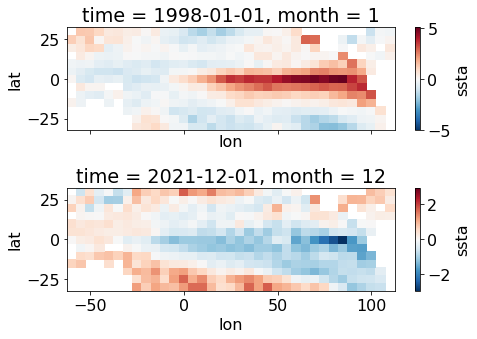

In [3]:
fig, axs = plt.subplots(2, sharex=True)
for i, t in enumerate(['1998-01', '2021-12']):
    da.sel(time=t).plot(ax=axs[i])

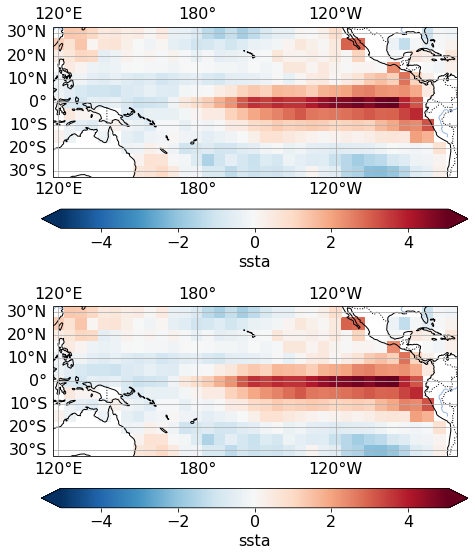

In [4]:
import cartopy as ctp
fig = plt.figure(figsize=(8,8))
for i, t in enumerate(['1998-01-01', '2021-12-01']):
    ax = fig.add_subplot(2,1,i+1, projection=ctp.crs.PlateCarree(central_longitude=180))
    ut.plot_map(da.sel(time='1998-01-01'), ax=ax, central_longitude=180)

El Nino Southern Oscillation is usually defined using the average time series over the Nino3.4 region.

![Nino](img/nino_regions.png)

Taken from https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

In [5]:
nino34_region = da.sel(lat=slice(-5,5), lon=[10, 60])
nino34 = nino34_region.mean(dim=('lon', 'lat'), skipna=True)

Text(0, 0.5, 'Nino3.4 index')

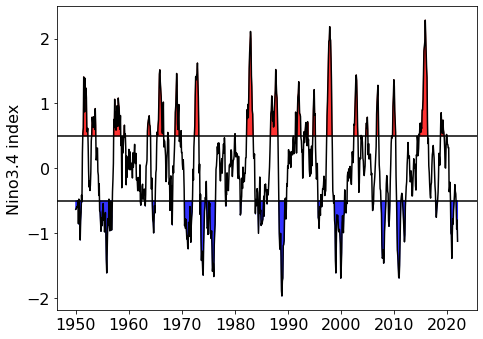

In [6]:
# Plot Nino3.4 index
fig, ax = plt.subplots()
ax.plot(nino34['time'].data, nino34.data, '-k')
ax.fill_between(nino34['time'].data, nino34.data, y2=0.5, where=nino34.data >= 0.5, color='r', alpha=0.8)
ax.fill_between(nino34['time'].data, nino34.data, y2=-0.5, where=nino34.data <= -0.5, color='b', alpha=0.8)
ax.axhline(-0.5, color='k')
ax.axhline(0.5, color='k')
ax.set_ylabel('Nino3.4 index')

### Preprocess data for pytorch

When using pytorch we have to define our dataset as pytorch.Tensors

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SSTA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.dataarray = dataarray
        self.time = self.dataarray['time'].data
        self.lat = self.dataarray['lat'].data
        self.lon = self.dataarray['lon'].data
        
        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0,:])
        self.X = X[:, ~self.idx_nan]
        

    def __len__(self):
        return self.X.shape[0]
    

    def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            
            x = torch.from_numpy(self.X[idx]).float()
            label = {'idx': torch.Tensor(idx)}

            return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.NaN
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map 
        

Lets have a look at our pytoch Dataset class.

In [8]:
dataset = SSTA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of datapoint: {x_dim}")

Shape of datapoint: 394


We split the data randomly in a training and validation dataset. For pytorch we pack our data into a loader for efficient parallelization.

In [9]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])
# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Autoencoder

Now we can start with NN by defining our encoder and decoder network.

TODO: Picture of Autoencoder

In [10]:
class AE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()
        

Initialize our AE model:

In [11]:
ae = AE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in ae.parameters() if p.requires_grad))

Number of trainable parameters of our model: 406924


### Training function

In [12]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

### Execute the training and validation functions

In [13]:
# Training parameters
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        ae, val_loader
    )
    train_epoch_loss = train_epoch(
        ae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 10
Train Loss: 100.6524
Val Loss: 148.9014
Epoch 2 of 10
Train Loss: 82.6239
Val Loss: 78.1209
Epoch 3 of 10
Train Loss: 81.2053
Val Loss: 79.0478
Epoch 4 of 10
Train Loss: 81.5102
Val Loss: 76.9456
Epoch 5 of 10
Train Loss: 78.2121
Val Loss: 75.9057
Epoch 6 of 10
Train Loss: 78.0057
Val Loss: 76.9063
Epoch 7 of 10
Train Loss: 76.4917
Val Loss: 74.9172
Epoch 8 of 10
Train Loss: 75.9754
Val Loss: 74.7714
Epoch 9 of 10
Train Loss: 75.6326
Val Loss: 74.2470
Epoch 10 of 10
Train Loss: 74.5314
Val Loss: 75.4108


Evaluate training by plotting the loss function.

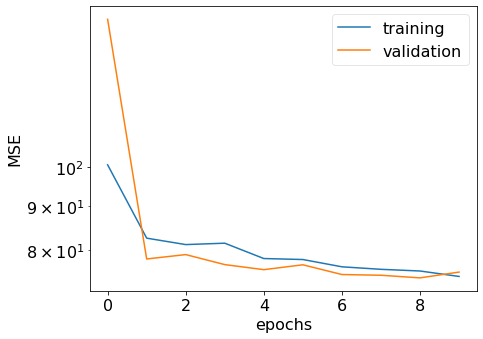

In [14]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

Qualitative comparison of reconstructed images and input images:

{'ax': <GeoAxesSubplot:>,
 'im': <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f2f8a85f3a0>}

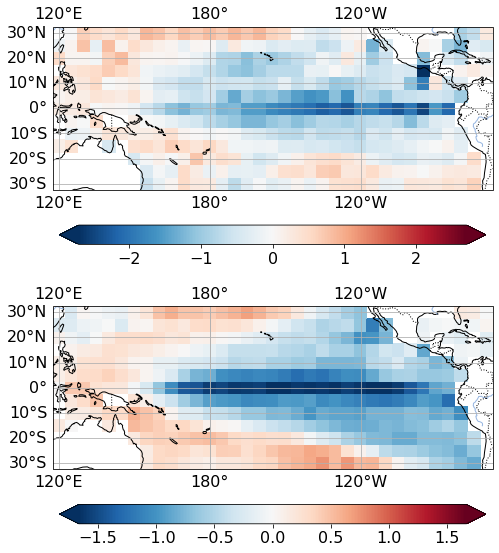

In [16]:
# select random inputs from validataion dataset
x, _ = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, z = ae.forward(x.to(ae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec)

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180))
)
ut.plot_map(da_in, ax=ax1, central_longitude=180)
ut.plot_map(da_rec, ax=ax2, central_longitude=180)


### Latent space

We now have a look at the low dimensional representation of the data, called latent space. 

We first have to push the data through the encoder and store their latent values.

In [22]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader 

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, _ = x
            x_hat, z = model.forward(x.to(model.device))
            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
            else:
                encode['z'] = np.vstack([encode['z'], z.cpu().detach().numpy()])
    return encode

encode = encoding(ae, train_loader)

We can now plot the encodings:

Text(0, 0.5, '$z_2$')

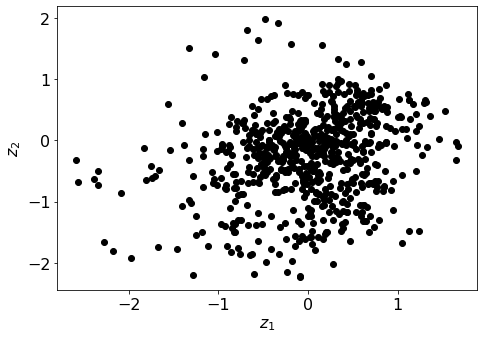

In [26]:
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")